# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use Stanford Dogs. A subset of ImageNet-1k chosen for the task of fine-grained image categorization AKA texture AKA fluffiness.
https://www.tensorflow.org/datasets/catalog/stanford_dogs

Rotate the EfficientNet output vectors with PCA to create "meatier" feature vectors.

SHOULD THIS HAVE A SEPARATE PCA ROTATION FOR EVERY CONVOLUTION? 1280 CONVOLUTIONS, 1280 PCA SESSIONS? OR ONE PCA SESSION FOR ALL OF THE CONVOLUTIONS?

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.decomposition import IncrementalPCA as PCA
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

gc.collect()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


0

In [3]:
import tensorflow_datasets as tfds

batch_size = 64
pca_batch_size = 2048

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_pca = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

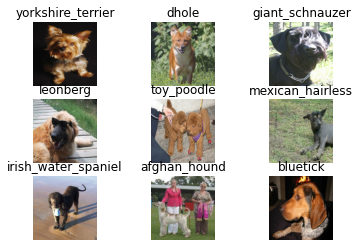

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

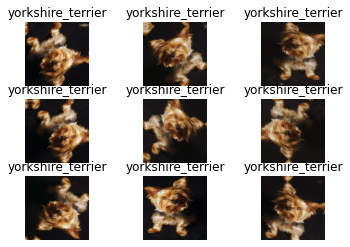

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_pca = ds_train
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

ds_pca = ds_pca.batch(batch_size=pca_batch_size, drop_remainder=True)


A little code for plotting the results.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# PCA Rotation Matrix
Create a PCA projection matrix from EfficientNetB0 vectors based on training dataset.

First, create a model that takes Stanford Dog training or test sets and projects them to the end of CNN pipeline, before the final classification top.

In [10]:
NUM_FEATURES=7*7*1280

def build_model(num_classes, output_size=NUM_FEATURES):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)
    # x = layers.Reshape((7*7*NUM_FEATURES,1))(x)
    # print(x.shape)
    # outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, x, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
# with strategy.scope():
bare_model = build_model(NUM_CLASSES)
bare_model.summary()
pred1 = bare_model.predict(np.zeros((1, 224, 224, 3)))
print(pred1.shape)

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 effb0 (Functional)          (None, 7, 7, 1280)        4049571   
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________
(1, 7, 7, 1280)


In [11]:
# pca = PCA()

# batches = np.zeros((pca_batch_size, NUM_FEATURES), dtype='float32')
# index = 0
# sample = None
# prev_x = None
# deltas = []

# for (images, labels) in ds_pca:
#     # print(images.shape)
#     pred = bare_model.predict(images)
#     # print(pred.shape)
#     flat = pred.reshape((pca_batch_size, NUM_FEATURES))
#     if sample is None:
#         sample = flat[0].reshape((NUM_FEATURES))
#         print('sample:', sample)
#     for i in range(flat.shape[0]):
#         single = flat[i].reshape((NUM_FEATURES,))
#         batches[index + i] = single
#     index = index + flat.shape[0]
#     if index == batches.shape[0]:
#         pca.partial_fit(batches)
#         x = pca.transform(sample.reshape((-1, NUM_FEATURES)))
#         # print(x.shape, x[0,:6])
#         if prev_x is not None:
#             delta = np.mean(np.abs(prev_x - x))
#             print('mean delta:', delta)
#             deltas.append(delta)
#         index = 0
#         prev_x = x

# print('matrix:', pca.components_.shape)

# projected = pca.transform(batches)
# print(projected.shape)
# print(pca.components_)

In [12]:
def plot_progress(deltas):
    x = np.array(range(len(deltas)), dtype='int32')
    y = np.asarray(deltas)
    #create basic scatterplot
    plt.plot(x, y, 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b)

    # flush
    plt.show()

In [13]:
# pca = PCA()
# sample = None
# prev_x = None
# deltas = []

# def run_pca(ds):
#     global pca, sample, prev_x, deltas
#     for (images, labels) in ds:
#         gc.collect()
#         # print(images.shape)
#         pred = bare_model.predict(images)
#         pred = pred.reshape((pca_batch_size, NUM_FEATURES))
#         # print(pred.shape)
#         if sample is None:
#             sample = pred[0]
#             print('sample:', sample)
#         pca.partial_fit(pred)
#         # Measure delta of one projected sample across successive training rounds
#         x = pca.transform(sample.reshape((-1, NUM_FEATURES)))
#         # print(x.shape, x[0,:6])
#         if prev_x is not None:
#             delta = np.mean(np.abs(prev_x - x))
#             print('mean delta:', delta)
#             deltas.append(delta)
#         prev_x = x
#         pred = None




In [14]:
pca = PCA()
sample = None
prev_x = None
deltas = []

def forever_ds(ds):
    def cycle():
        while True:
            for (images, labels) in ds:
                yield images
    return cycle

ds_cycle = forever_ds(ds_train)

def run_pca(ds):
    global pca, sample, prev_x, deltas
    gc.collect()
    all_preds = np.zeros((pca_batch_size, NUM_FEATURES), dtype='float32')
    group = 0
    num_images = 0
    for (images, labels) in ds:        
        # print('group', group)
        # print(images.shape)
        num_images = num_images + images.shape[0]
        preds = bare_model.predict(images)
        preds = preds.reshape((batch_size, NUM_FEATURES))
        # print(preds.shape)
        all_preds[group*batch_size:(group+1)*batch_size, :] = preds[0:batch_size, :]
        if sample is None:
            sample = all_preds[0]
            print('sample:', sample)
        group = group + 1
        if group == pca_batch_size // batch_size:
            print('partial_fit')
            pca.partial_fit(all_preds)
            preds = None
            # Measure delta of one projected sample across successive training rounds
            x = pca.transform(sample.reshape((-1, NUM_FEATURES)))
            # print(x.shape, x[0,:6])
            if prev_x is not None:
                delta = np.mean(np.abs(prev_x - x))
                print('mean delta:', delta)
                deltas.append(delta)
            prev_x = x
            group = 0
    print('num_images', num_images)


We're going to train the IncrementalPCA object to project embedding vectors to a new basis where the information is pushed toward one end of the vector. We will do several round of training using the entire training dataset. Each round uses a shuffled version of the dataset, which should assist with getting to a final PCA projection.

We will plot the mean delta across each sample during the training of IncrementalPCA. This shows that as the PCA is fine-tuned, the projection of the original sample jumps around less and less.

Sun Jun  5 21:35:41 UTC 2022
batch 1
sample: [-0.2784514  -0.09536923 -0.24563369 ... -0.17296305 -0.16575646
 -0.2783687 ]
partial_fit


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


partial_fit
mean delta: 3.5063751226233224
partial_fit
mean delta: 4.304684406887902
partial_fit
mean delta: 4.711904320694938
partial_fit
mean delta: 5.789500656328215
num_images 11968


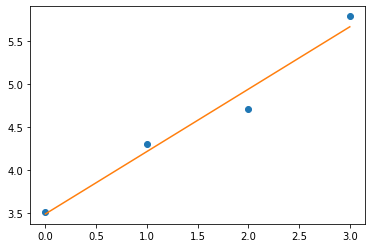

In [15]:
!date
print('batch 1')
run_pca(ds_train)
plot_progress(deltas)


Sun Jun  5 21:53:04 UTC 2022
batch 2
partial_fit
mean delta: 5.48051592652449
partial_fit
mean delta: 2.792086350355295
partial_fit
mean delta: 2.6966267538479713
partial_fit
mean delta: 2.830652451925884
partial_fit
mean delta: 2.7214392298250516
num_images 11968


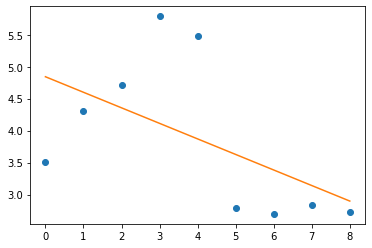

In [16]:
!date
print('batch 2')
run_pca(ds_train)
plot_progress(deltas)

Sun Jun  5 22:13:24 UTC 2022
batch 3
partial_fit
mean delta: 2.7770490934678045
partial_fit
mean delta: 2.552703478115137
partial_fit
mean delta: 2.6564689822140117
partial_fit
mean delta: 2.5838725088741503
partial_fit
mean delta: 2.4656809188370943
num_images 11968


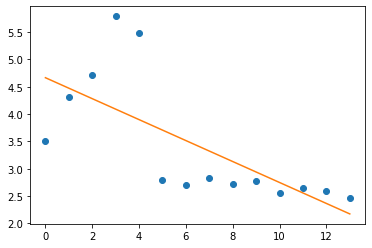

In [17]:
!date
print('batch 3')
run_pca(ds_train)
plot_progress(deltas)

Sun Jun  5 22:33:53 UTC 2022
batch 4
partial_fit
mean delta: 2.6011389311226907
partial_fit
mean delta: 2.41180250644822
partial_fit
mean delta: 2.5057549445746212
partial_fit
mean delta: 2.396190898556251
partial_fit
mean delta: 2.430692973469078
num_images 11968


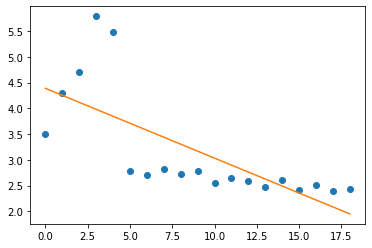

In [18]:
!date
print('batch 4')
run_pca(ds_train)
plot_progress(deltas)

Sun Jun  5 22:54:30 UTC 2022
batch 5
partial_fit
mean delta: 2.4096592934627017
partial_fit
mean delta: 2.4147660809591587
partial_fit
mean delta: 2.279210803568457
partial_fit
mean delta: 2.2815241661173884
partial_fit
mean delta: 2.2861268384757714
num_images 11968


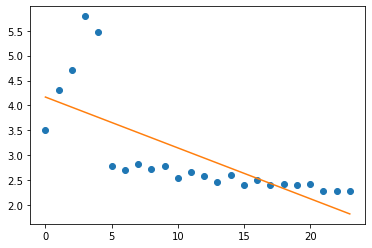

Sun Jun  5 23:14:57 UTC 2022


In [19]:
!date
print('batch 5')
run_pca(ds_train)
plot_progress(deltas)
!date


In [ ]:
!date
print('batch 6')
run_pca(ds_train)
print('batch 7')
run_pca(ds_train)
print('batch 8')
run_pca(ds_train)
print('batch 9')
run_pca(ds_train)
print('batch 10')
run_pca(ds_train)
print('batch 11')
run_pca(ds_train)
plot_progress(deltas)
!date
print('matrix.shape:', pca.components_.shape)
print('total samples:', pca.n_samples_seen_)

Sun Jun  5 23:14:58 UTC 2022
batch 6
partial_fit
mean delta: 2.277082114541964
partial_fit
mean delta: 2.246110321665234
partial_fit
mean delta: 2.268009092775627
partial_fit
mean delta: 2.163909279689695
partial_fit
mean delta: 2.1138633887701177
num_images 11968
batch 7
partial_fit
mean delta: 2.217615377351352
partial_fit
mean delta: 2.171112582913877
partial_fit
mean delta: 2.185344810309416
partial_fit
mean delta: 2.0296138132610717
partial_fit
mean delta: 2.027123524212266
num_images 11968
batch 8
partial_fit
mean delta: 2.139413539100198
partial_fit
mean delta: 2.092937180851921
partial_fit
mean delta: 2.150807986860412
partial_fit
mean delta: 2.008946443698166
partial_fit
mean delta: 1.9852620602872368
num_images 11968
batch 9
partial_fit
mean delta: 2.0199742934949856
partial_fit
mean delta: 2.0339164774470255
partial_fit
mean delta: 2.0300191803537433
partial_fit
mean delta: 1.934427060341902
partial_fit


In [ ]:
!date
print('batch 12')
run_pca(ds_train)
print('batch 13')
run_pca(ds_train)
print('batch 14')
run_pca(ds_train)
print('batch 15')
run_pca(ds_train)
print('batch 16')
run_pca(ds_train)
plot_progress(deltas)
!date
print('matrix.shape:', pca.components_.shape)
print('total samples:', pca.n_samples_seen_)

Now that we have a fully trained PCA object, let's plot the classic display of what PCA is all about. PCA projects an N-dimensional space such that the members of the 0-th cell of the output vector has the highest standard deviation, the 1-th cell the second highest stdev, etc.

In [ ]:
for (images, labels) in ds_pca:
    pred = bare_model.predict(images)
    pred = pred.reshape((pca_batch_size, NUM_FEATURES))
    break
projected = pca.transform(pred)
pred = None
transp = np.transpose(projected)
print(transp.shape)
std = np.ndarray.std(transp, axis=-1)
print(std.shape)
x = np.array(range(std.shape[0]), dtype='int32')
y = np.asarray(std)
#create basic scatterplot
plt.plot(x, y, 'o')

What this means for our purposes is that we have "concentrated" the variation between embeddings into a smaller set of numbers.

# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [ ]:
!pip install -q git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN2D

## Trained embeddings from pre-trained weights

---



Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset. We do three different trainings:


1.   Train a standard Global-Average-Pooling top
2.   Train a simple top using a Bilinear layer
3.   Train a simple top using PCA to project the EfficientNetB0 embeddings to a more "concentrated" vector space




In [ ]:

def build_model(num_classes, bilinear=False, pca_matrix=None):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear and pca_matrix is not None:
        print('pca_matrix.shape', pca_matrix.shape)
        x_shape = x.shape
        print(x_shape)
        x = layers.Flatten()(x)
        pca_dense = layers.Dense(pca_batch_size, use_bias=False, name='pca_project')
        x = pca_dense(x)
        x = layers.Reshape((1,1,pca_batch_size))(x)
        x = BilinearCNN2D()([x, x])
    elif bilinear:
        # x = layers.Reshape((1,1,NUM_FEATURES))(x)        
        x = BilinearCNN2D()([x, x])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # before model.compile(), input size to pca_dense is not known
    if pca_matrix is not None:
        dense_weights = pca_dense.get_weights()
        print(dense_weights[0].shape)
        print(pca_matrix.shape)
        assert dense_weights[0].shape == pca_matrix.shape
        dense_weights[0] = pca_matrix
        pca_dense.set_weights(dense_weights)
        pca_dense.trainable = False
    return model

junk = build_model(NUM_CLASSES, bilinear=True)
junk.summary()
junk = build_model(NUM_CLASSES, bilinear=True, pca_matrix=np.transpose(pca.components_))
junk.summary()

First, train a standard classification top.

In [ ]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES)

# epochs = 80  # @param {type: "slider", min:2, max:80}
# model.summary()
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
#                 callbacks=[early_stopping], verbose=2)
# plot_hist(hist)

In [ ]:
# _, generic_accuracy_train =  model.evaluate(ds_train)
# _, generic_accuracy_test =  model.evaluate(ds_test)

Next, train a Bilinear top.

In [ ]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES, bilinear=True)

# epochs = 80  # @param {type: "slider", min:2, max:80}
# model.summary()
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
#                 callbacks=[early_stopping], verbose=2)
# plot_hist(hist)

In [ ]:
# _, bilinear_accuracy_train =  model.evaluate(ds_train)
# _, bilinear_accuracy_test =  model.evaluate(ds_test)

Finally, train a Bilinear top using PCA to project the EfficientNetB0 embeddings into a more semantically enriched subset.

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES, bilinear=True, pca_matrix=np.transpose(pca.components_))

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [ ]:
_, pca_accuracy_train =  model.evaluate(ds_train)
_, pca_accuracy_test =  model.evaluate(ds_test)

In [ ]:
# print('Accuracy for Generic Top, Training/Testing\n\t', generic_accuracy_train, '\n\t', generic_accuracy_test)
# print('Accuracy for Bilinear Top, Training/Testing\n\t', bilinear_accuracy_train, '\n\t', bilinear_accuracy_test)
print('Accuracy for Bilinear PCA Top, Training/Testing\n\t', pca_accuracy_train, '\n\t', pca_accuracy_test)